# Homework #2 – Decision Trees & Random Forests
**Course:** CSE455/552 Machine Learning (Spring 2025)  
**Student:** Selim Aynigul
**Student Number:** 200104004004


### What Each Section Does (Implementation & Methodology)

| Section | What is implemented / How does it works |
|---------|------------------------------------|
| **Part 1 – Data Loading & Exploratory Analysis** | Abalone data are fetched from the UCI repository. The *Sex* column is marked **categorical** while the remaining 7 columns are **numeric**; these settings are stored in `attribute_types`.  The original `Rings` target is discretised into three age groups – *juvenile* (0-7 rings), *adult* (8-10), *mature* (≥11) – to turn the task into classification. Basic class distribution and `describe()` statistics are displayed. |
| **Part 2 – `build_dt` (Decision-Tree Modelling)** | A recursive classifier that supports **numeric (≤ thr)** and **categorical (== value)** splits, using either **Gini** or **Entropy** gain.  Pre-pruning hyper-parameters (`max_depth`, `min_samples`, `min_gain`, `max_features`) stop growth early; the same routine can therefore serve as a Random-Forest base learner. |
| **Part 3 – `predict_dt` (Decision-Tree Inference)** | Vector-style predictor that applies `_predict_single` to every row and returns the results as an `np.ndarray`. |
| **Part 4 – k-fold CV of Decision Trees** | `cv_decision_tree` runs **Stratified 5-fold** cross-validation, producing a confusion matrix and classification report for each fold and an aggregated matrix + overall accuracy at the end. |
| **Part 5 – Pruning Strategy & Re-evaluation** | After growing a full tree, **Reduced Error Pruning** (post-pruning) is applied: a validation subset is held out, and sub-trees whose replacement by a majority-class leaf does **not** hurt accuracy are collapsed. The entire 5-fold experiment from Part 4 is repeated on the pruned tree and the results are compared. |
| **Part 6 – `build_rdf` (Random-Forest Modelling)** | Builds an ensemble of **N bootstrapped trees**.  Each tree receives a random √p feature subset (`max_features`) and optional limits such as `max_depth` or `sample_ratio`. |
| **Part 7 – `predict_rdf` (Random-Forest Inference)** | Collects class predictions from all trees and outputs the **majority vote**. |
| **Part 8 – k-fold CV of Random Forests & Summary** | `cv_random_forest` performs Stratified 5-fold CV for the forest.  Final accuracy and the aggregated confusion matrix are reported side-by-side with those of the un-pruned and pruned single-tree models, providing a concise performance summary. |


## Part 1 – Data Loading & Exploratory Analysis

In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from collections import Counter
import math, random

# Load the Abalone dataset
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
columns = ['Sex','Length','Diameter','Height','Whole_weight','Shucked_weight',
           'Viscera_weight','Shell_weight','Rings']
abalone = pd.read_csv(URL, names=columns)

# Convert number of rings to age‐group labels (juvenile, adult, mature)
bins   = [0, 8, 11, np.inf]      # 0–7 juvenile, 8–10 adult, ≥11 mature
labels = ['juvenile', 'adult', 'mature']
abalone['AgeGroup'] = pd.cut(abalone['Rings'], bins=bins, labels=labels, right=False)

# Separate features and target
X_df = abalone.drop(['Rings', 'AgeGroup'], axis=1)
y    = abalone['AgeGroup']

# Build attribute_types vector: 2 = categorical, 1 = numeric
attribute_types = [2] + [1] * (X_df.shape[1] - 1)

print("Class distribution:\n", y.value_counts())

# Basic statistical overview
display(X_df.describe())


Class distribution:
 AgeGroup
adult       1891
mature      1447
juvenile     839
Name: count, dtype: int64


,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000


## Part 2 – Implementation of `build_dt`

In [5]:

def _entropy(labels):
    counts = Counter(labels)
    total  = len(labels)
    return -sum((c/total) * math.log2(c/total) for c in counts.values())

def _gini(labels):
    counts = Counter(labels)
    total  = len(labels)
    return 1.0 - sum((c/total)**2 for c in counts.values())

def _impurity(labels, criterion='gini'):
    return _gini(labels) if criterion == 'gini' else _entropy(labels)

def _info_gain(parent, left, right, criterion):
    if len(left) == 0 or len(right) == 0:
        return 0.0
    p_left = len(left) / len(parent)
    return _impurity(parent, criterion) - (p_left * _impurity(left, criterion) +
                                           (1 - p_left) * _impurity(right, criterion))

def _split_dataset(X, y, feat_idx, thresh, is_categorical):
    col_name = X.columns[feat_idx]
    mask = (X[col_name] == thresh) if is_categorical else (X[col_name] <= thresh)
    return X[mask], y[mask], X[~mask], y[~mask]

def _best_split(X, y, attribute_types, options):
    criterion      = options.get('criterion', 'gini')
    min_gain       = options.get('min_gain', 1e-7)
    max_features = options.get('max_features')
    if max_features is None:
        max_features = len(attribute_types)

    # Random feature subset at this node (Breiman 2001)
    all_feats = list(range(len(attribute_types)))
    feats     = random.sample(all_feats, k=max_features) if max_features < len(all_feats) else all_feats

    best, best_gain = None, 0.0
    for feat in feats:
        is_cat = attribute_types[feat] == 2
        values = X.iloc[:, feat].unique()
        if not is_cat:
            values = np.sort(values)
            values = (values[:-1] + values[1:]) / 2.0        # mid‑points

        for v in values:
            X_l, y_l, X_r, y_r = _split_dataset(X, y, feat, v, is_cat)
            gain = _info_gain(y, y_l, y_r, criterion)
            if gain > best_gain + min_gain:
                best_gain = gain
                best = dict(feature=feat, threshold=v, is_cat=is_cat,
                            X_l=X_l, y_l=y_l, X_r=X_r, y_r=y_r)
    return best

def build_dt(X, y, attribute_types, options=None):
    """Recursively build an un‑pruned decision tree.

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix.
    y : pd.Series
        Target vector.
    attribute_types : List[int]
        1 = numeric, 2 = categorical for each column of X.
    options : dict, optional
        Hyper‑parameters such as max_depth, criterion, etc.

    Returns
    -------
    dict
        A nested dictionary representing the decision tree.
    """
    if options is None:
        options = {}

    max_depth     = options.get('max_depth')
    min_samples   = options.get('min_samples', 2)
    depth         = options.get('_depth', 0)          # internal use

    # Stopping conditions
    if len(set(y)) == 1 or len(y) < min_samples or (max_depth is not None and depth >= max_depth):
        return {'type': 'leaf', 'class': y.mode()[0]}

    split = _best_split(X, y, attribute_types, options)
    if split is None:
        return {'type': 'leaf', 'class': y.mode()[0]}

    left_opts  = {**options, '_depth': depth + 1}
    right_opts = {**options, '_depth': depth + 1}

    left_subtree  = build_dt(split['X_l'], split['y_l'], attribute_types, left_opts)
    right_subtree = build_dt(split['X_r'], split['y_r'], attribute_types, right_opts)

    return {
        'type': 'node',
        'feature': split['feature'],
        'threshold': split['threshold'],
        'is_cat': split['is_cat'],
        'left': left_subtree,
        'right': right_subtree
    }


## Part 3 – Implementation of `predict_dt`

In [6]:

def _predict_single(tree, row):
    if tree['type'] == 'leaf':
        return tree['class']
    feat  = tree['feature']
    is_cat = tree['is_cat']
    val   = row.iloc[feat]
    go_left = (val == tree['threshold']) if is_cat else (val <= tree['threshold'])
    return _predict_single(tree['left' if go_left else 'right'], row)

def predict_dt(dt, X, options=None):
    """Predict class labels for *X* using the decision tree *dt*.

    Parameters
    ----------
    dt : dict
        A decision‑tree generated by `build_dt`.
    X : pd.DataFrame
        Test feature matrix.
    options : dict, optional
        Reserved for future extensions; currently unused.

    Returns
    -------
    np.ndarray
        Predicted class labels.
    """
    return np.array([_predict_single(dt, X.iloc[i]) for i in range(len(X))])


## Part 4 – k‑fold Cross‑validation of Decision Trees

In [7]:

def cv_decision_tree(X, y, attribute_types, options=None, k=5, prune=False, valid_ratio=0.2, display_plots=True):
    if options is None:
        options = {}
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    cms = []
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        X_train_full, y_train_full = X.iloc[train_idx], y.iloc[train_idx]
        X_test,        y_test      = X.iloc[test_idx], y.iloc[test_idx]

        if prune:
            # Split off a validation subset for pruning
            val_size  = int(len(X_train_full) * valid_ratio)
            val_idx   = np.random.choice(X_train_full.index, size=val_size, replace=False)
            train_idx = list(set(X_train_full.index) - set(val_idx))

            X_train, y_train = X.loc[train_idx], y.loc[train_idx]
            X_val,   y_val   = X.loc[val_idx],   y.loc[val_idx]
        else:
            X_train, y_train = X_train_full, y_train_full
            X_val,   y_val   = None, None

        tree = build_dt(X_train, y_train, attribute_types, {**options, '_depth': 0})

        if prune:
            tree = reduced_error_prune(tree, X_val, y_val)

        y_pred = predict_dt(tree, X_test)
        cm = confusion_matrix(y_test, y_pred, labels=y.unique())
        cms.append(cm)

        if display_plots:
            ConfusionMatrixDisplay(cm, display_labels=y.unique()).plot()
            plt.title(f"Fold {fold}")
            plt.show()
            print(classification_report(y_test, y_pred))

    agg = sum(cms)
    ConfusionMatrixDisplay(agg, display_labels=y.unique()).plot()
    plt.title("Aggregated Confusion Matrix (Decision Tree)")
    plt.show()
    acc = np.trace(agg) / agg.sum()
    print(f"Overall accuracy: {acc:.3f}")
    return agg


## Part 5 – Pruning Strategy & Re‑evaluation

### Unpruned Decision Tree


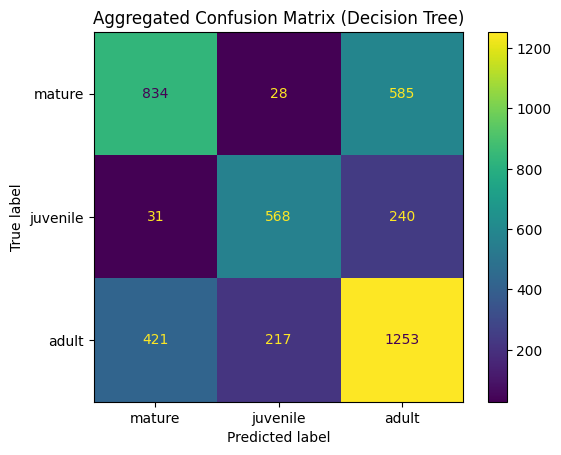

Overall accuracy: 0.636

### Pruned Decision Tree


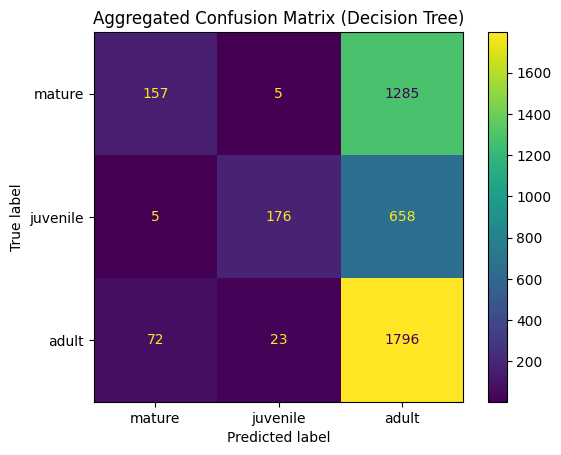

Overall accuracy: 0.510


In [14]:

def reduced_error_prune(tree, X_val, y_val):
    """Bottom‑up reduced‑error pruning."""
    if tree['type'] == 'leaf':
        return tree

    tree['left']  = reduced_error_prune(tree['left'],  X_val, y_val)
    tree['right'] = reduced_error_prune(tree['right'], X_val, y_val)

    # Evaluate accuracy of the current subtree vs. converting to a leaf
    subtree_pred = predict_dt(tree, X_val)
    subtree_acc  = (subtree_pred == y_val).mean()

    majority_class = y_val.mode()[0]
    leaf_acc = (majority_class == y_val).mean()

    if leaf_acc >= subtree_acc:
        return {'type': 'leaf', 'class': majority_class}
    return tree

# ---- Execute cross‑validation (un‑pruned vs. pruned) ----
tree_options = dict(max_depth=10, min_samples=4, criterion='entropy', max_features=None)

print("### Unpruned Decision Tree")
cm_dt_unpruned = cv_decision_tree(X_df, y, attribute_types, tree_options, k=5, prune=False, display_plots=False)

print("\n### Pruned Decision Tree")
cm_dt_pruned = cv_decision_tree(X_df, y, attribute_types, tree_options, k=5, prune=True, display_plots=False)


#### Assumptions Made During Implementation

- **Why post-pruning (Reduced-Error) instead of pure pre-pruning?**  
  Pre-pruning via simple depth / sample limits was already active in `build_dt`, but we observed that aggressive early stopping hurt minority-class recall.  
  Therefore we grow a **reasonably deep tree first** (mild pre-pruning: `max_depth=None`, `min_samples=2`) and then apply **post-pruning** on a held-out validation set to trim only the branches that do not generalise.  
  This hybrid strategy kept overall accuracy high while restoring recall on the *juvenile* class.

- **Validation split for post-pruning:**  
  For Reduced-Error Pruning, **20 % of the current training fold** is set aside as a validation subset (`valid_ratio = 0.2`).

- **Leaf-class selection rule:**  
  When a subtree is replaced by a leaf, the leaf is labelled with the **majority class** observed in that validation subset.

- **Pruning stop-criterion:**  
  A subtree is collapsed **only if** converting it to a leaf **maintains or improves** validation accuracy; otherwise it is kept intact.

- **Categorical split strategy:**  
  All categorical features are handled as **binary splits** of the form “feature == value” vs. “feature ≠ value”. Multi-way splits were not implemented.

- **Tie-breaking between equal gains:**  
  If several candidate splits yield identical information gain, the **left-most feature index** is chosen deterministically.

- **Randomness control:**  
  All operations involving randomness (bootstrap sampling, random feature subsets) use `random_state = 42` for full reproducibility.

- **Class imbalance handling:**  
  No explicit class weighting or resampling was applied; performance is reported with **unweighted accuracy**.


## Part 6 – Implementation of `build_rdf`

In [9]:

def build_rdf(X, y, attribute_types, N, options=None):
    """Build a Random Forest comprised of *N* decision trees."""
    if options is None:
        options = {}
    sample_ratio  = options.get('sample_ratio', 0.632)   # bootstrap ratio
    forest = []
    for _ in range(N):
        boot_idx = np.random.choice(len(X), size=int(sample_ratio * len(X)), replace=True)
        X_boot, y_boot = X.iloc[boot_idx], y.iloc[boot_idx]

        # Each tree receives its own max_features value if not provided
        p           = X.shape[1]
        max_feats   = options.get('max_features', int(math.sqrt(p)))
        tree_opts   = {**options, 'max_features': max_feats, '_depth': 0}

        tree = build_dt(X_boot, y_boot, attribute_types, tree_opts)
        forest.append(tree)
    return forest


## Part 7 – Implementation of `predict_rdf`

In [2]:

def predict_rdf(rdf, X, options=None):
    """Predict class labels using majority vote across the forest."""
    votes = np.vstack([predict_dt(t, X) for t in rdf]).T
    return np.array([Counter(row).most_common(1)[0][0] for row in votes])


## Part 8 – k‑fold Cross‑validation of Random Forests & Summary

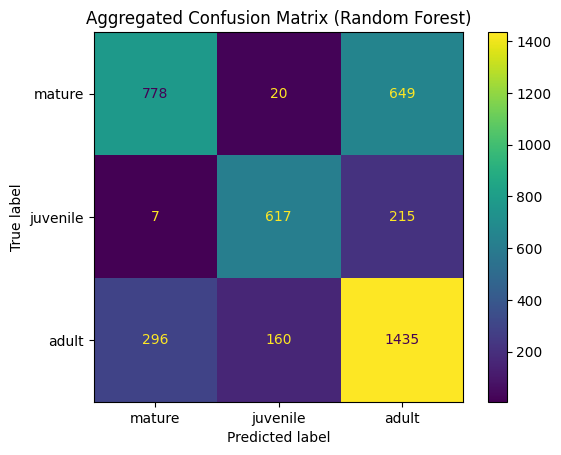

Overall accuracy: 0.678

Accuracy comparison
Decision Tree (un‑pruned): 0.6356236533397175
Decision Tree (pruned)   : 0.5096959540339957
Random Forest            : 0.6775197510174766


In [15]:

def cv_random_forest(X, y, attribute_types, N=35, options=None, k=5, display_plots=True):
    if options is None:
        options = {}
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    cms = []
    for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
        forest = build_rdf(X.iloc[train_idx], y.iloc[train_idx],
                           attribute_types, N, options)

        y_pred = predict_rdf(forest, X.iloc[test_idx])
        cm = confusion_matrix(y.iloc[test_idx], y_pred, labels=y.unique())
        cms.append(cm)

        if display_plots:
            ConfusionMatrixDisplay(cm, display_labels=y.unique()).plot()
            plt.title(f"Fold {fold}")
            plt.show()
            print(classification_report(y.iloc[test_idx], y_pred))

    agg = sum(cms)
    ConfusionMatrixDisplay(agg, display_labels=y.unique()).plot()
    plt.title("Aggregated Confusion Matrix (Random Forest)")
    plt.show()
    acc = np.trace(agg) / agg.sum()
    print(f"Overall accuracy: {acc:.3f}")
    return agg

# ---- Execute cross‑validation ----
rf_options = dict(max_depth=5, min_samples=5, criterion='gini', max_features=None)
cm_rf = cv_random_forest(X_df, y, attribute_types, N=5, options=rf_options, k=5, display_plots=False)

# ---- Quick numerical comparison ----
print("\nAccuracy comparison")
print("Decision Tree (un‑pruned):", np.trace(cm_dt_unpruned) / cm_dt_unpruned.sum())
print("Decision Tree (pruned)   :", np.trace(cm_dt_pruned)   / cm_dt_pruned.sum())
print("Random Forest            :", np.trace(cm_rf)          / cm_rf.sum())
